In [1]:
import os

os.environ["QUIMB_NUM_THREAD_WORKERS"] = "1"

In [2]:
import sys

sys.path.append("../../src")

In [3]:
import matplotlib.pylab as plt
import matplotlib.font_manager as fm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
import copy
plt.rcParams.update({'font.size': 20})

In [4]:
import quimb as qu
import quimb.tensor as qtn

In [5]:
import qiskit
from qiskit import Aer
from qiskit.quantum_info.operators.operator import Operator
from qiskit.circuit import Parameter, ParameterVector
from qiskit import QuantumCircuit, transpile

In [6]:
import seaborn as sns
import scipy
import numpy as np

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from utilities import *
from preprocess import (
    shadow_results_to_data_vec,
    shadow_seqs_to_op_array_rz,
    shadow_seqs_to_op_array,
    pure_measurement,
    clifford_rz_unitaries_vT,
    clifford_measurements_vT,
    clifford_unitaries_vT,
    val_rz_unitaries_vT,
    val_unitaries_vT,
    val_measurements_vT,
    clifford_param_dict,
    validation_param_dict,
)

In [46]:
from optimize import TNOptimizer
from fit_functions import (
    compute_likelihood,
    causality_keys_to_op_arrays,
    compute_probabilities,
)

In [9]:
from process_tensor_networks import (
    create_PT_PEPO_guess,
    expand_initial_guess_,
    create_PEPO_X_decomp,
)

In [10]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.standard_errors import (
    depolarizing_error,
    coherent_unitary_error,
)

In [11]:
error_X = scipy.linalg.expm(-1.0j * np.pi / 32 * X)

In [12]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

noise_model = noise.NoiseModel()
p1Q = 0.002
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), "sx")
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(error_X), "sx")

In [13]:
NSTEPS = 9
nQ = 1
basis_gates = ["cx", "rz", "sx", "x", "unitary"]

In [14]:
def create_env_IA(rxx, ryy, rzz):
    U = scipy.linalg.expm(
        -1.0j * 0.5 * (rxx * np.kron(X, X) + ryy * np.kron(Y, Y) + rzz * np.kron(Z, Z))
    )

    U = qiskit.quantum_info.operators.operator.Operator(U, 4, 4)
    return U

In [15]:
def append_PT_gates(circ, env_IA, timesteps, crosstalk_IA=None):
    """
    Function for the in-place insertion of the parametrised DD sequence into a circuit.

    circ : QuantumCircuit
        Broader circuit into which we're appending our sequence.
        This function should be called at the appropriate gap.

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    q_sys : int
        System (target) qubit from the broader circuit

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure

    """
    if NSTEPS < 10:

        param_dict = {
            (q, t): [
                Parameter(f"t{t}_q{q}_x"),
                Parameter(f"t{t}_q{q}_y"),
                Parameter(f"t{t}_q{q}_z"),
            ]
            for q in range(nQ)
            for t in range(NSTEPS + 1)
        }

        # can modify circuit structure here if desired

        for i in range(timesteps):
            for j in range(nQ):
                circ.u(*param_dict[(j, i)], j + 1)
            for j in range(nQ):
                circ.append(env_IA, [0, j + 1])
                if crosstalk_IA is not None and j < nQ - 1:
                    circ.append(crosstalk_IA, [j + 1, j + 2])

        for j in range(nQ):
            circ.u(*param_dict[(j, NSTEPS)], j + 1)

        for j in range(nQ):
            circ.measure(j + 1, j)

    else:
        circ_params = ParameterVector("x", 3 * NSTEPS)

        # can modify circuit structure here if desired
        # circ.u3(x_params[0], y_params[0], z_params[0], q_sys)
        circ.u3(*circ_params[0:3], 1)

        for i in range(1, timesteps - 1):

            circ.u(*circ_params[3 * i : 3 * (i + 1)], 1)
            circ.append(env_IA, [0, 1])

        circ.u(*circ_params[3 * (i + 1) : 3 * (i + 2)], 1)
        circ.measure(1, 0)

    return None


def base_PT_circ_template(timesteps, env_IA, backend, crosstalk_IA=None):
    """
    Create the QuantumCircuit of interest. This template leaves the DD sequence parametrised for later
    process tensor or other validation circuits

    qubit_list : list
        List of physical qubits for passing to the transpilation function

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure
    """

    qreg_size = nQ + 1

    circ = QuantumCircuit(qreg_size, nQ)
    circ.ry(np.pi / 4, 0)
    # Insert fancy circuit here

    append_PT_gates(
        circ, env_IA, timesteps, crosstalk_IA=crosstalk_IA
    )  # for insertion of DD sequence

    # Insert fancy circuit here

    return transpile(circ, basis_gates=basis_gates, optimization_level=1)

In [16]:
def shadow_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        clifford_seq = list(np.random.randint(0, 24, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [clifford_param_dict[N] for param_set in clifford_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(clifford_seq).T)
    return shadow_circs, shadow_sequences


def validation_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        val_seq = list(np.random.randint(0, 100, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [validation_param_dict[N] for param_set in val_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(val_seq).T)
    return shadow_circs, shadow_sequences

In [17]:
env_IA = create_env_IA(np.pi / 15, np.pi / 15, np.pi / 10)
crosstalk_IA = create_env_IA(0, 0, np.pi / 8)
PT_template_t = base_PT_circ_template(NSTEPS, env_IA, simulator, crosstalk_IA)
PT_template_t.global_phase = 0

/Users/gregorywhite/.pyenv/versions/3.9/envs/qiskit-PTNs/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [18]:
PT_template_t.draw(fold=-1)

┌────────┐  ┌────┐    ┌──────────┐   ┌────┐                    ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                  ┌──────────┐                                                                     
q_0: ───┤ Rz(-π) ├──┤ √X ├────┤ Rz(3π/4) ├───┤ √X ├────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├──────────────────────────────────────────────────────────────────┤0         ├─────────────────────────────────────────────────────────────────────
     ┌──┴────────┴─┐├────┤┌───┴──────────┴──┐├────┤┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌─────────────────┐┌────┐┌──────────────────┐┌─┐
q_1: ┤ Rz(t0_q0_z) ├┤ √X ├┤ Rz(t0_q0_x + π) ├┤ √X ├┤ Rz(t0_q0_y + 3π) ├┤1         ├┤ Rz(t1_q0_z) ├┤ √X ├┤ Rz(t1_q0_x + π) ├┤ √X ├┤ Rz(t1_q0_y + 3π) ├┤1         ├┤ Rz(t2_q0_z) ├┤ √X ├┤ Rz(t2_q0_x + π) ├┤ √X ├┤ Rz(t2_q0_y + 3π) ├┤1         ├┤ Rz(t3_q0_z) ├┤ √X ├┤ Rz(t3_q0_x + π) ├┤ √X ├┤ Rz(t3_q0_y + 3π) ├┤1         ├┤ Rz(t4_q0_z) ├┤ √X ├┤ Rz(t4_q0_x + π) ├┤ √X ├┤ Rz(t4_q0_y + 3π) ├┤1         ├┤ Rz(t5_q0_z) ├┤ √X ├┤ Rz(t5_q0_x + π) ├┤ √X ├┤ Rz(t5_q0_y + 3π) ├┤1         ├┤ Rz(t6_q0_z) ├┤ √X ├┤ Rz(t6_q0_x + π) ├┤ √X ├┤ Rz(t6_q0_y + 3π) ├┤1         ├┤ Rz(t7_q0_z) ├┤ √X ├┤ Rz(t7_q0_x + π) ├┤ √X ├┤ Rz(t7_q0_y + 3π) ├┤1         ├┤ Rz(t8_q0_z) ├┤ √X ├┤ Rz(t8_q0_x + π) ├┤ √X ├┤ Rz(t8_q0_y + 3π) ├┤1         ├┤ Rz(t9_q0_z) ├┤ √X ├┤ Rz(t9_q0_x + π) ├┤ √X ├┤ Rz(t9_q0_y + 3π) ├┤M├
     └─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└──────────┘└─────────────┘└────┘└─────────────────┘└────┘└──────────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [19]:
no_val_shots = 16384

val_circs, val_sequences = validation_PT_circs(300, PT_template_t)

val_job = simulator.run(val_circs, shots=no_val_shots, noise_model=noise_model)
val_dict = {"res": val_job.result().get_counts(), "seqs": val_sequences}

val_shadow_sequences = val_dict["seqs"]
val_data, val_keys = shadow_results_to_data_vec(
    val_dict["res"], shots=no_val_shots, nQ=nQ
)

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_44367/2000206260.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [20]:
no_jobs = 20
circ_shots = 1024
job_dict = {}
counter = 0

In [23]:
for i in range(no_jobs):
    tmp_circs, tmp_sequences = shadow_PT_circs(300, PT_template_t)
    tmp_job = simulator.run(tmp_circs, shots=circ_shots, noise_model=noise_model)
    tmp_dict = {"res": tmp_job.result().get_counts(), "seqs": tmp_sequences}
    job_dict[i] = tmp_dict
    counter += 1

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_44367/2000206260.py:10: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [24]:
shadow_sequences = []
for J in job_dict.items():
    shadow_sequences += J[1]["seqs"]

In [25]:
training_data = []
for i in range(len(job_dict)):
    training_data += job_dict[i]["res"]

In [26]:
training_data_flat, training_keys = shadow_results_to_data_vec(
    training_data, circ_shots, nQ
)
val_shadow_sequences = val_dict["seqs"]
val_data, val_keys = shadow_results_to_data_vec(val_dict["res"], shots=16384, nQ=nQ)

In [27]:
new_shadow_sequences = []
for seq in shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_shadow_sequences.append(tmp)

In [28]:
new_val_sequences = []
for seq in val_shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_val_sequences.append(tmp)

In [29]:
training_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_shadow_sequences, training_keys, pure_measurement, clifford_rz_unitaries_vT
)

In [30]:
val_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_val_sequences, val_keys, pure_measurement, val_rz_unitaries_vT
)

In [31]:
training_sequences_v = shadow_seqs_to_op_array(
    new_shadow_sequences, training_keys, clifford_measurements_vT, clifford_unitaries_vT
)

In [32]:
val_sequences_v = shadow_seqs_to_op_array(
    new_val_sequences, val_keys, val_measurements_vT, val_unitaries_vT
)

In [33]:
nS = NSTEPS

no_epochs = 600
batch_size = 1000
K_lists = [[1] + [1 for j in range(nS - 1)] + [1] for i in range(nQ)]
vertical_bonds = [[1] + [1 for i in range(nQ - 3)] + [1] for j in range(nS)] + [
    [1 for i in range(nQ - 1)]
]
horizontal_bonds = [1 for i in range(nS)]
initial_guess = create_PT_PEPO_guess(nS, nQ, horizontal_bonds, vertical_bonds, K_lists)
initial_guess = qu.tensor.tensor_2d.TensorNetwork2DFlat.from_TN(
    initial_guess,
    site_tag_id="q{}_I{}",
    Ly=nS + 1,
    Lx=nQ,
    row_tag_id="ROWq{}",
    col_tag_id="COL{}",
)

real_K_lists = [[2] + [1 for j in range(nS - 1)] + [2] for i in range(nQ)]
real_vertical_bonds = [[2 for i in range(nQ - 1)]] + [
    [2] + [2 for i in range(nQ - 3)] + [2] for j in range(nS)
]
real_horizontal_bonds = [[2 for i in range(nS + 1)] for i in range(nQ)]
expand_initial_guess_(
    initial_guess,
    real_K_lists,
    real_horizontal_bonds,
    real_vertical_bonds,
    rand_strength=0.05,
    squeeze=False,
)
initial_guess.squeeze_()
Lx = initial_guess.Lx
Ly = initial_guess.Ly

In [34]:
X_guess = create_PEPO_X_decomp(nS, nQ)

In [35]:
instructions = {
    "normal": {
        "initial_tn": initial_guess,
        "training_seqs": training_sequences_v,
        "val_seqs": val_sequences_v,
        "likelihood_const": False,
    },
    "X_decomp": {
        "initial_tn": initial_guess & X_guess,
        "training_seqs": training_sequences_v_rz,
        "val_seqs": val_sequences_v_rz,
        "likelihood_const": True,
    },
}

In [36]:
data_entropy = (
    -(1 / len(training_data_flat))
    * np.array(training_data_flat)
    @ np.log(np.array(training_data_flat))
)
v_data_entropy = -(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(val_data))
print(data_entropy)
print(v_data_entropy)

0.28893279855465426
0.2908970258077338


In [37]:
iterations = int(2 * no_epochs * len(training_data_flat) / batch_size)
print(iterations)

14400


In [38]:
mode = "X_decomp"

In [41]:
# PTT accounting for gate errors
Xoptmzr = TNOptimizer(
    instructions[mode][
        "initial_tn"
    ],  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [42]:
X_pepo_opt = Xoptmzr.optimize(iterations)  # regular

+0.2851683 [best loss: +0.2801076] [best val: +0.2909521; (14367)]: : 14401it [29:58,  8.01it/s]                         


In [43]:
Xoptmzr.val_best - v_data_entropy

5.509044325802126e-05

In [44]:
best_val_mpo_X = Xoptmzr.best_val_mpo

In [47]:
v_predictions = compute_probabilities(
    best_val_mpo_X,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions = sum(val_data) * v_predictions / sum(v_predictions)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions)))

0.2909436249164973


In [48]:
v_predictions_norm = []
for i in range((2**nQ) * 300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        v_predictions_norm.append(v)
v_predictions_norm = np.array(v_predictions_norm)

In [50]:
from scipy.stats import describe

In [51]:
describe(np.abs(np.array(val_data) - v_predictions_norm))

DescribeResult(nobs=600, minmax=(2.613663673400879e-05, 0.015091627836227417), mean=0.0043482824911673865, variance=1.0154598990534102e-05, skewness=0.8569300446406416, kurtosis=0.22596701274140285)

In [52]:
v_fidelities = []
for i in range(300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    v_fidelities.append(hellinger_fidelity(tmp_v, actual_v))

In [53]:
describe(v_fidelities)

DescribeResult(nobs=300, minmax=(0.999722586573213, 1.0000000831332656), mean=0.9999624491103257, variance=2.4052622448465282e-09, skewness=-2.086558537764297, kurtosis=4.596342440229119)

In [54]:
no_batches = Xoptmzr._nBatches
epoch_losses = [
    Xoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(Xoptmzr._n / no_batches))
]
epoch_val_losses = [
    Xoptmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(Xoptmzr._n / no_batches))
]

In [55]:
mode = "normal"

In [56]:
# PTT with assumed perfect inputs
Uoptmzr = TNOptimizer(
    instructions[mode][
        "initial_tn"
    ],  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [57]:
U_pepo_opt = Uoptmzr.optimize(iterations)  # regular

+0.3014000 [best loss: +0.2927638] [best val: +0.3033467; (12340)]: : 14401it [06:05, 39.38it/s]                         


In [58]:
Uoptmzr.val_best - v_data_entropy

0.012449697510366176

In [59]:
best_val_mpo_U = Uoptmzr.best_val_mpo

In [60]:
v_predictions_U = compute_probabilities(
    best_val_mpo_U,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions_U = sum(val_data) * v_predictions_U / sum(v_predictions_U)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions_U)))

0.30327954467902996


In [61]:
v_predictions_norm_U = []
for i in range((2**nQ) * 300):
    tmp_v = v_predictions_U[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        v_predictions_norm_U.append(v)
v_predictions_norm_U = np.array(v_predictions_norm_U)

In [62]:
describe(np.abs(np.array(val_data) - v_predictions_norm_U))

DescribeResult(nobs=600, minmax=(0.00016108155250549316, 0.37806862592697144), mean=0.07922370879600446, variance=0.004087502068721623, skewness=1.210596050733733, kurtosis=1.8772703649381963)

In [63]:
v_fidelities_U = []
for i in range(300):
    tmp_v = v_predictions_U[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    v_fidelities_U.append(hellinger_fidelity(tmp_v, actual_v))

In [64]:
describe(v_fidelities_U)

DescribeResult(nobs=300, minmax=(0.8552857568416563, 1.0000000193736964), mean=0.9874821572188875, variance=0.0003366865895952348, skewness=-2.861685588846335, kurtosis=11.717922948319949)

In [65]:
no_batches_U = Uoptmzr._nBatches
epoch_losses_U = [
    Uoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(Uoptmzr._n / no_batches))
]
epoch_val_losses_U = [
    Uoptmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(Uoptmzr._n / no_batches))
]

In [70]:
import seaborn as sns

sns.set_style("whitegrid")

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-e

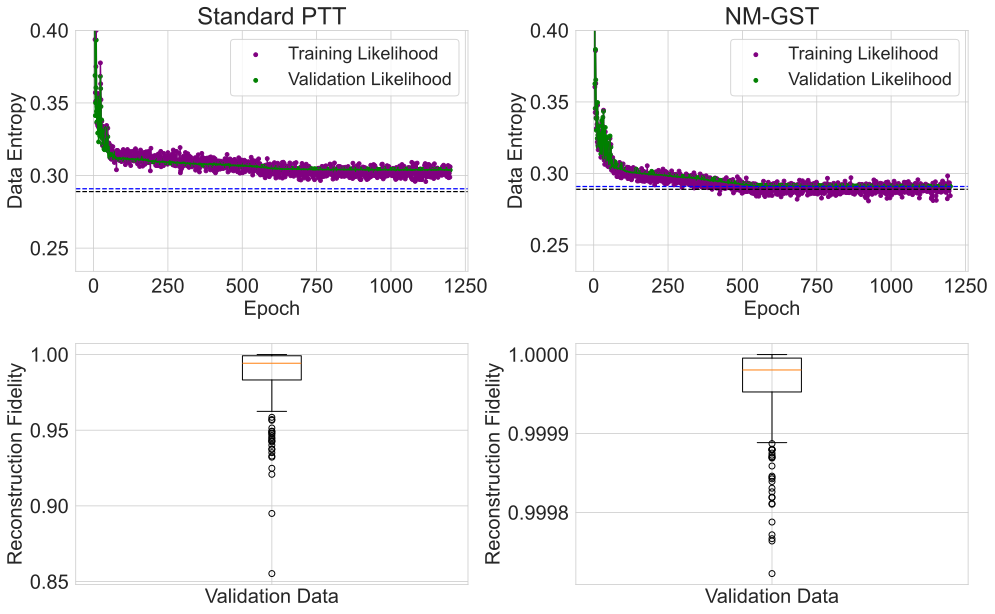

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))


ax[0, 1].plot(epoch_losses, color="purple")
ax[0, 1].plot(epoch_val_losses, color="green")
ax[0, 1].scatter(
    range(len(epoch_losses)),
    epoch_losses,
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 1].scatter(
    range(len(epoch_val_losses)),
    epoch_val_losses,
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 1].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 1].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 1].set_title("NM-GST", fontsize=24)
ax[0, 1].set_ylabel("Data Entropy")
ax[0, 1].set_ylim(None, 0.4)
ax[0, 1].set_xlabel("Epoch")
ax[0, 1].legend(fontsize=18)

xticks = ax[0, 1].get_xticklabels()
yticks = ax[0, 1].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)


ax[0, 0].plot(epoch_losses_U, color="purple")
ax[0, 0].plot(epoch_val_losses_U, color="green")
ax[0, 0].scatter(
    range(len(epoch_losses_U)),
    epoch_losses_U,
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 0].scatter(
    range(len(epoch_val_losses_U)),
    epoch_val_losses_U,
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 0].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 0].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 0].set_title("Standard PTT", fontsize=24)
ax[0, 0].set_ylabel("Data Entropy")
ax[0, 0].set_ylim(None, 0.4)
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].legend(fontsize=18)

xticks = ax[0, 0].get_xticklabels()
yticks = ax[0, 0].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)

# Bottom left: Box plot for v_fidelities_U
plt.subplot(2, 2, 3)
plt.boxplot(np.array(v_fidelities_U))
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)


# Bottom right: Box plot for v_fidelities
# plt.subplot(2,2,4, sharey=plt.gca())
plt.subplot(2, 2, 4)
# plt.yscale('log')
plt.boxplot(np.array(v_fidelities))
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

plt.subplots_adjust(hspace=0.3, wspace=0.275)

# plt.savefig('Coherent_Error_Benchmark.pdf', bbox_inches = 'tight')
plt.show()